---
# House Rent Prediction
---

#### Check out the Dataset-Glossory.txt and readme.txt file

| Column Name       | Description                                                |
|-------------------|------------------------------------------------------------|
| BHK               | Number of Bedrooms, Hall, Kitchen                          |
| Rent              | Rent of the Houses/Apartments/Flats                        |
| Size              | Size of the Houses/Apartments/Flats in Square Feet         |
| Floor             | Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.) |
| Area Type         | Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area |
| Area Locality     | Locality of the Houses/Apartments/Flats                   |
| City              | City where the Houses/Apartments/Flats are Located        |
| Furnishing Status | Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished |
| Tenant Preferred  | Type of Tenant Preferred by the Owner or Agent            |
| Bathroom          | Number of Bathrooms                                       |
| Point of Contact  | Whom should you contact for more information regarding the Houses/Apartments/Flats |

### Import Libraries

In [1]:
import os
import math
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import statistics

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import keras
import tensorflow as tf
from sklearn import metrics
from scipy.stats import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
hd = pd.read_csv('House_Rent_Dataset.csv')
print("(rows, columns) :", hd.shape)
hd.sample(5)

(rows, columns) : (4746, 12)


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
3552,2022-07-11,2,12000,550,Ground out of 1,Super Area,Choolaimedu,Chennai,Unfurnished,Bachelors/Family,2,Contact Owner
3496,2022-06-10,3,17000,1200,1 out of 3,Super Area,Velachery,Chennai,Semi-Furnished,Bachelors/Family,2,Contact Owner
2868,2022-06-02,2,40000,900,Ground out of 3,Carpet Area,Vasant Kunj,Delhi,Furnished,Bachelors/Family,2,Contact Owner
1923,2022-06-04,1,12500,600,1 out of 1,Super Area,New Bel Road,Bangalore,Unfurnished,Bachelors/Family,1,Contact Owner
3289,2022-07-06,3,47500,1920,6 out of 15,Super Area,Thoraipakkam,Chennai,Semi-Furnished,Family,3,Contact Agent


In [3]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [4]:
# hd.isnull().sum()
# No null values

### Dealing with Outliers

In [5]:
def var_summary(x):
# UC = MEAN + 2 STD
    uc = x.mean()+(2*x.std())
    lc = x.mean()-(2*x.std())
    
    for i in x:
        if i<lc or i>uc:
            count = 1             # This means that column is having an OUTLier
        else:
            count = 0             # That column in not having an outliers
            
    outlier_flag = count
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), 
                      x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),x.quantile(0.10),
                      x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                      x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max() , 
                      lc , uc,outlier_flag],
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                         'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,
                         'MAX','LC','UC','outlier_flag'])

In [6]:
numeric_cols = []
for cols in hd:
    if hd[cols].dtypes == 'int64':
        numeric_cols.append(cols)
        
print(numeric_cols)

['BHK', 'Rent', 'Size', 'Bathroom']


In [7]:
hd[numeric_cols].apply(lambda x: var_summary(x))

,BHK,Rent,Size,Bathroom
N,4746.000000,4.746000e+03,4.746000e+03,4746.000000
NMISS,0.000000,0.000000e+00,0.000000e+00,0.000000
SUM,9890.000000,1.660789e+08,4.591711e+06,9330.000000
MEAN,2.083860,3.499345e+04,9.674907e+02,1.965866
MEDIAN,2.000000,1.600000e+04,8.500000e+02,2.000000
STD,0.832256,7.810641e+04,6.342023e+02,0.884532
VAR,0.692650,6.100612e+09,4.022126e+05,0.782396
MIN,1.000000,1.200000e+03,1.000000e+01,1.000000
P1,1.000000,4.000000e+03,7.000000e+01,1.000000
P5,1.000000,6.000000e+03,2.000000e+02,1.000000


#### Nah I dont believe this, lets plot the taget variable

<Axes: xlabel='Rent'>

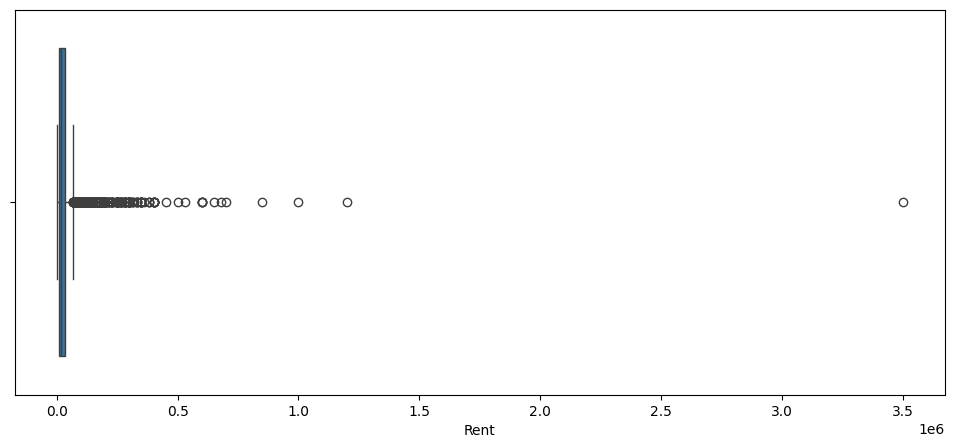

In [8]:
plt.figure(figsize=(12,5))
sns.boxplot(data = hd, x = 'Rent')

In [9]:
hd = hd[hd['Rent'] <= 200000]

<Axes: xlabel='Rent'>

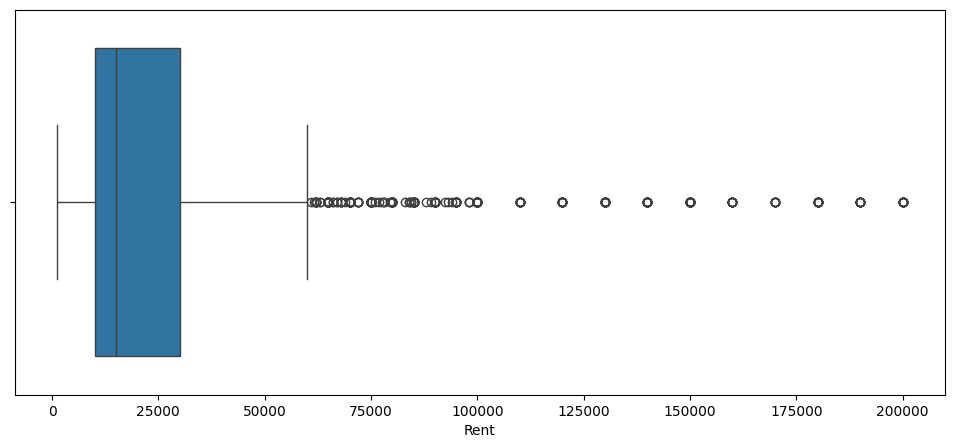

In [10]:
plt.figure(figsize=(12,5))
sns.boxplot(data = hd, x = 'Rent')

### Data Visualization

<Axes: xlabel='City', ylabel='Rent'>

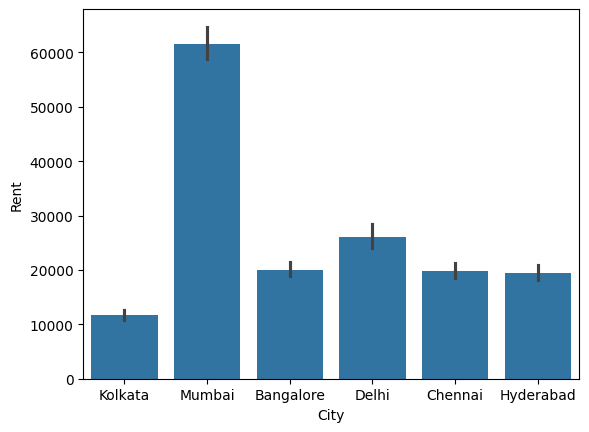

In [11]:
sns.barplot(data = hd, x = 'City', y = 'Rent')
# It seems that Mumbai has the highest Rent amongst all other 

In [12]:
hd['Area Type'].value_counts()

Area Type
Super Area     2436
Carpet Area    2209
Built Area        2
Name: count, dtype: int64

<Axes: xlabel='City', ylabel='Rent'>

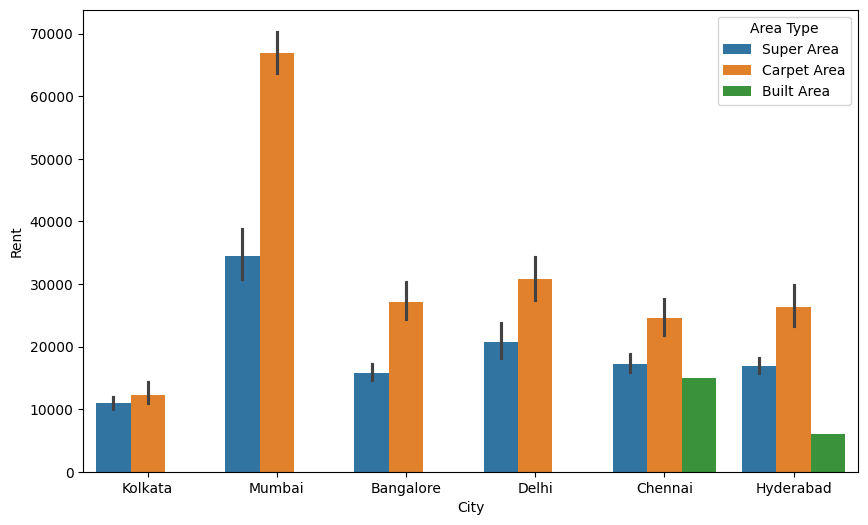

In [13]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Area Type')

<Axes: xlabel='City', ylabel='Rent'>

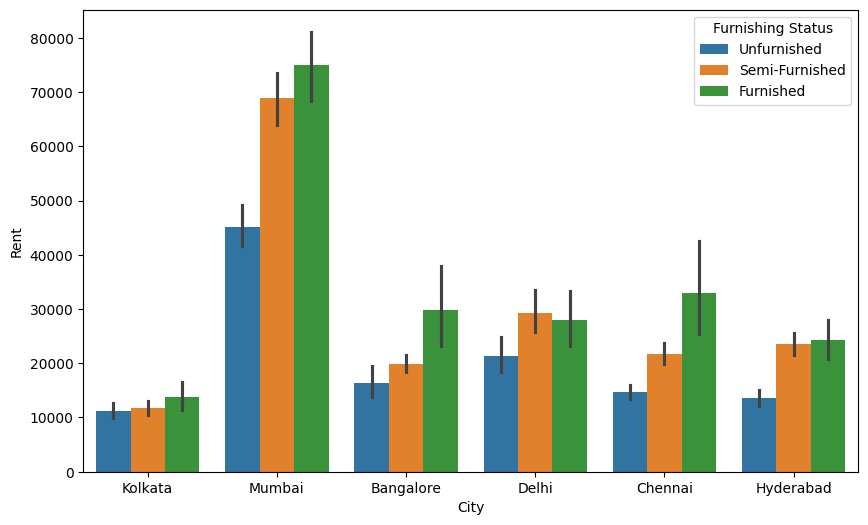

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Furnishing Status')

<Axes: xlabel='City', ylabel='Rent'>

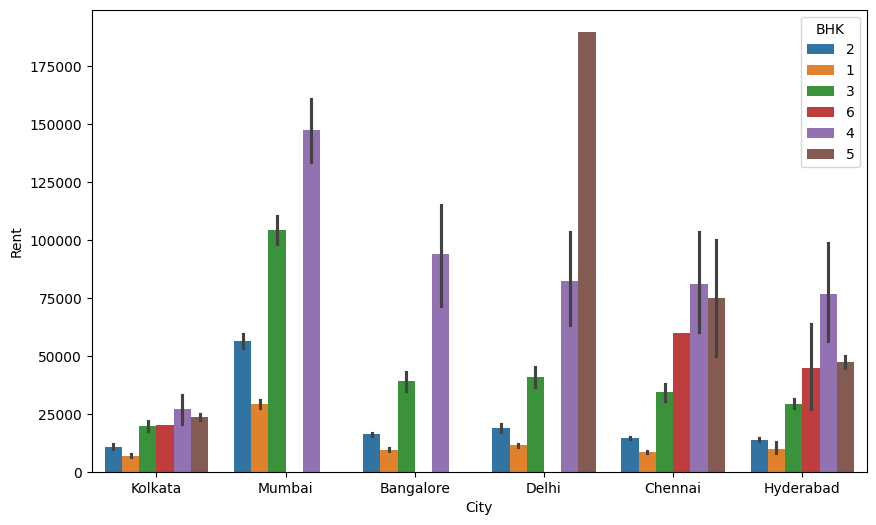

In [15]:
plt.figure(figsize=(10,6))
# sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'BHK')
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = hd['BHK'].astype(str)) 

In [16]:
hd[hd['BHK'] == 6]

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
83,2022-06-21,6,20000,1000,1 out of 1,Super Area,Sonarpur,Kolkata,Semi-Furnished,Bachelors/Family,2,Contact Owner
3584,2022-06-02,6,60000,1800,1 out of 3,Super Area,Besant Nagar,Chennai,Furnished,Bachelors/Family,6,Contact Owner
4350,2022-06-18,6,60000,2800,Ground out of 3,Super Area,"Boduppal, NH 2 2",Hyderabad,Furnished,Bachelors/Family,7,Contact Owner
4479,2022-07-07,6,20000,2400,Ground out of 1,Super Area,"Mallikarjuna Nagar, Secunderabad",Hyderabad,Unfurnished,Family,4,Contact Owner
4518,2022-05-12,6,35000,3400,Ground out of 2,Super Area,Rampally,Hyderabad,Unfurnished,Bachelors/Family,7,Contact Owner
4648,2022-07-06,6,80000,4500,1 out of 2,Super Area,"Kakateeya Nagar, Secunderabad",Hyderabad,Semi-Furnished,Bachelors/Family,6,Contact Owner
4696,2022-07-06,6,30000,4200,Ground out of 2,Super Area,Kuntloor,Hyderabad,Semi-Furnished,Bachelors/Family,5,Contact Owner


<Axes: xlabel='City', ylabel='Rent'>

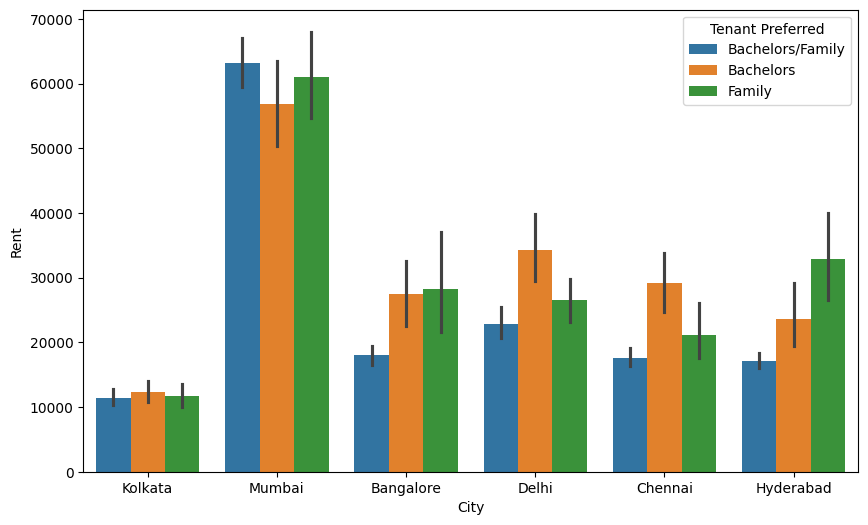

In [17]:
plt.figure(figsize=(10,6))
sns.barplot(data = hd, x = 'City', y = 'Rent', hue = 'Tenant Preferred')

In [18]:
hd['Bathroom'].value_counts()

Bathroom
2     2285
1     1474
3      732
4      116
5       28
6        8
7        3
10       1
Name: count, dtype: int64

In [19]:
hd.describe()

,BHK,Rent,Size,Bathroom
count,4647.000000,4647.000000,4647.000000,4647.000000
mean,2.047558,27720.877986,935.207661,1.920164
std,0.795284,31960.289864,581.327095,0.824634
min,1.000000,1200.000000,10.000000,1.000000
25%,1.000000,10000.000000,550.000000,1.000000
50%,2.000000,15000.000000,825.000000,2.000000
75%,3.000000,30000.000000,1200.000000,2.000000
max,6.000000,200000.000000,8000.000000,10.000000


### Data Preprocessing 

In [20]:
hd1 = hd.copy()

In [21]:
hd1.sample(5)

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
2784,2022-05-27,2,6500,75,1 out of 1,Carpet Area,Najafgarh,Delhi,Unfurnished,Bachelors/Family,1,Contact Owner
4596,2022-06-29,3,40000,1965,10 out of 14,Super Area,"Nallagandla, Serilingampally",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
808,2022-06-30,3,90000,1500,6 out of 10,Carpet Area,Walkeshwar,Mumbai,Furnished,Bachelors/Family,3,Contact Agent
3721,2022-05-01,3,23000,1000,1 out of 3,Carpet Area,Keelkatalai,Chennai,Unfurnished,Bachelors,3,Contact Owner
3114,2022-06-14,2,16000,1000,1 out of 3,Super Area,Kodambakkam,Chennai,Semi-Furnished,Bachelors/Family,2,Contact Owner


In [22]:
drop_col = ['Posted On', 'Floor', 'Area Locality', 'Point of Contact']
hd1.drop(columns=drop_col, inplace = True)

In [23]:
hd1 = hd1[hd1['Area Type'] != 'Built Area']

In [24]:
hd1.sample(5)

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
840,2,65000,935,Super Area,Mumbai,Semi-Furnished,Bachelors/Family,2
1766,2,15000,1100,Carpet Area,Bangalore,Semi-Furnished,Bachelors/Family,2
4230,2,11000,1200,Super Area,Hyderabad,Unfurnished,Bachelors/Family,2
2996,2,12000,600,Super Area,Chennai,Furnished,Bachelors/Family,2
2817,3,30000,900,Carpet Area,Delhi,Semi-Furnished,Bachelors,3


### Data Scaling

In [25]:
print(hd1['Furnishing Status'].unique())
print(hd1['Area Type'].unique())
print(hd1['Tenant Preferred'].unique())

['Unfurnished' 'Semi-Furnished' 'Furnished']
['Super Area' 'Carpet Area']
['Bachelors/Family' 'Bachelors' 'Family']


In [26]:
hd1['Furnishing Status'] = hd1['Furnishing Status'].replace(['Furnished', 'Semi-Furnished','Unfurnished'], [2, 1, 0])
hd1['Area Type'] = hd1['Area Type'].replace(['Super Area','Carpet Area'],[1,0])
hd1['Tenant Preferred'] = hd1['Tenant Preferred'].replace(['Bachelors/Family', 'Bachelors', 'Family'],[2, 1, 0])

In [27]:
print(hd1['Furnishing Status'].unique())
print(hd1['Area Type'].unique())
print(hd1['Tenant Preferred'].unique())

[0 1 2]
[1 0]
[2 1 0]


In [28]:
hd1['City'].unique()

array(['Kolkata', 'Mumbai', 'Bangalore', 'Delhi', 'Chennai', 'Hyderabad'],
      dtype=object)

In [29]:
hd1.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
0,2,10000,1100,1,Kolkata,0,2,2
1,2,20000,800,1,Kolkata,1,2,1
2,2,17000,1000,1,Kolkata,1,2,1
3,2,10000,800,1,Kolkata,0,2,1
4,2,7500,850,0,Kolkata,0,1,1


In [30]:
hd1['City'] = hd1['City'].astype('category')
all_cat = hd1['City'].unique()
encoder = LabelEncoder()
encoder.fit(all_cat)
hd1['City'] = encoder.transform(hd1['City'])

In [31]:
hd1['City'].unique()

array([4, 5, 0, 2, 1, 3])

In [32]:
hd1.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
0,2,10000,1100,1,4,0,2,2
1,2,20000,800,1,4,1,2,1
2,2,17000,1000,1,4,1,2,1
3,2,10000,800,1,4,0,2,1
4,2,7500,850,0,4,0,1,1


Scaling 'Size' Column using MinMax or Standardization

In [33]:
hd2 = hd1.copy()

In [34]:
hd2.head()

,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom
0,2,10000,1100,1,4,0,2,2
1,2,20000,800,1,4,1,2,1
2,2,17000,1000,1,4,1,2,1
3,2,10000,800,1,4,0,2,1
4,2,7500,850,0,4,0,1,1


In [35]:
scaler1 = MinMaxScaler()
scaler2 = StandardScaler()
fin1 = scaler1.fit_transform(hd1[['Size']].values.reshape(-1, 1))
fin2 = scaler2.fit_transform(hd2[['Size']].values.reshape(-1, 1))
hd1['Size_Scaled_MinMax'] = fin1
hd2['Size_Standardized'] = fin2

In [36]:
hd1.drop(columns=['Size'], inplace = True)
hd2.drop(columns=['Size'], inplace = True)

In [37]:
hd1.rename(columns = {'Size_Scaled_MinMax':'Size_MM'}, inplace = True)
hd2.rename(columns = {'Size_Standardized':'Size_STD'}, inplace = True)

In [38]:
hd1.head()

,BHK,Rent,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Size_MM
0,2,10000,1,4,0,2,2,0.136421
1,2,20000,1,4,1,2,1,0.098874
2,2,17000,1,4,1,2,1,0.123905
3,2,10000,1,4,0,2,1,0.098874
4,2,7500,0,4,0,1,1,0.105131


In [39]:
hd2.head()

,BHK,Rent,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Size_STD
0,2,10000,1,4,0,2,2,0.283326
1,2,20000,1,4,1,2,1,-0.232711
2,2,17000,1,4,1,2,1,0.111314
3,2,10000,1,4,0,2,1,-0.232711
4,2,7500,0,4,0,1,1,-0.146705


### Train-Test Split and Model Training

In [40]:
X = hd1.drop(columns='Rent')
y = hd1['Rent']
# X = hd2.drop(columns='Rent')
# y = hd2['Rent']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=120)

In [42]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

# Iterating through each model and performing cross-validation
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE
    mean_rmse = rmse_scores.mean()
    std_rmse = rmse_scores.std()
    print(f"{model_name} RMSE: {mean_rmse:.2f} (+/- {std_rmse:.2f})")
    #                                           ^       ^
    # It represents the amount of variation or spread in RMSE values 

Linear Regression RMSE: 22898.04 (+/- 985.52)
Random Forest RMSE: 17048.79 (+/- 799.37)
Gradient Boosting RMSE: 16133.31 (+/- 1148.50)
SVR RMSE: 34064.01 (+/- 2074.77)
Lasso RMSE: 22898.02 (+/- 985.61)
Ridge RMSE: 22903.29 (+/- 984.59)
Decision Tree RMSE: 21181.75 (+/- 1194.22)
K-Nearest Neighbors RMSE: 18029.65 (+/- 519.65)


<br><br>
Cross-validation refers to the number of folds or partitions that your dataset is split into for cross-validation. It is commonly known as "k" in k-fold cross-validation. In this case, cv=5 means that your dataset is divided into 5 equal parts, or "folds." <br><br>
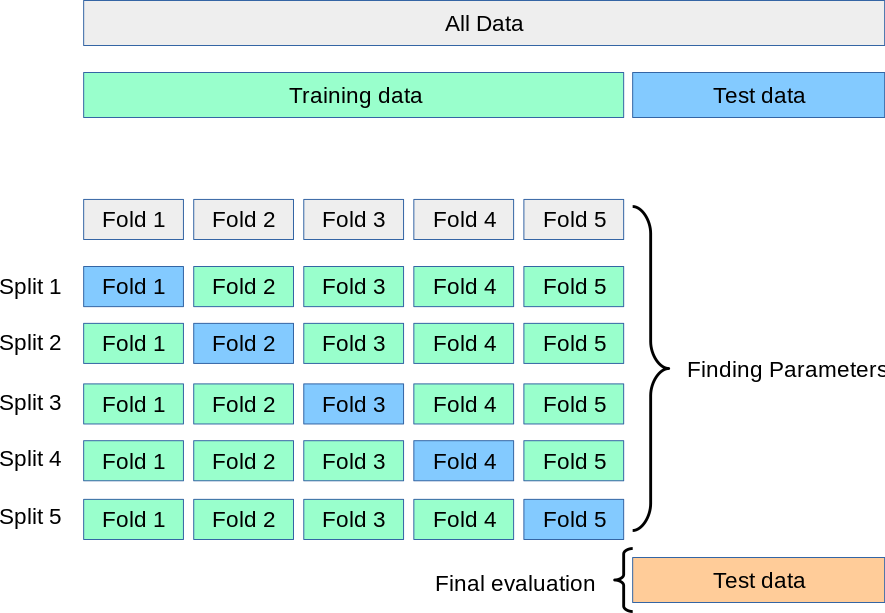
<br><br>

In [43]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [44]:
y_pred = model.predict(X_test)

In [45]:
print(X_train.shape)
print(X_train.shape[1])

(3483, 7)
7


In [46]:
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2S = r2_score(y_test, y_pred)
RMSE = math.sqrt(MSE)
# Adjusted R^2
n = len(y_test)
p = X_train.shape[1] 
ADJ_R2S = 1 - (1 - R2S) * (n - 1) / (n - p - 1)
print("The MSE:", round(MSE,3))
print("The RMSE:", round(RMSE,3))
print("The MAE:", round(MAE,3))
print("The R^2:", round(R2S, 2))
print("The ADJ_R^2:", round(ADJ_R2S, 2))

The MSE: 246218823.504
The RMSE: 15691.361
The MAE: 8714.678
The R^2: 0.76
The ADJ_R^2: 0.75


### Residual Analysis
 If all residuals lie exactly on the red line, it indicates that the model perfectly fits the data, but that doesn't necessarily mean it's the best model. It might be overfitting the data. We want the residuals to be randomly scattered around the red line, showing no clear patterns or trends, which indicates that the model's assumptions (homoscedasticity and normality) are met.

In [47]:
residuals = y_test - y_pred

In [48]:
data = {'Predicted' : y_pred,
           'Residuals' : residuals}
analysis = pd.DataFrame(data)

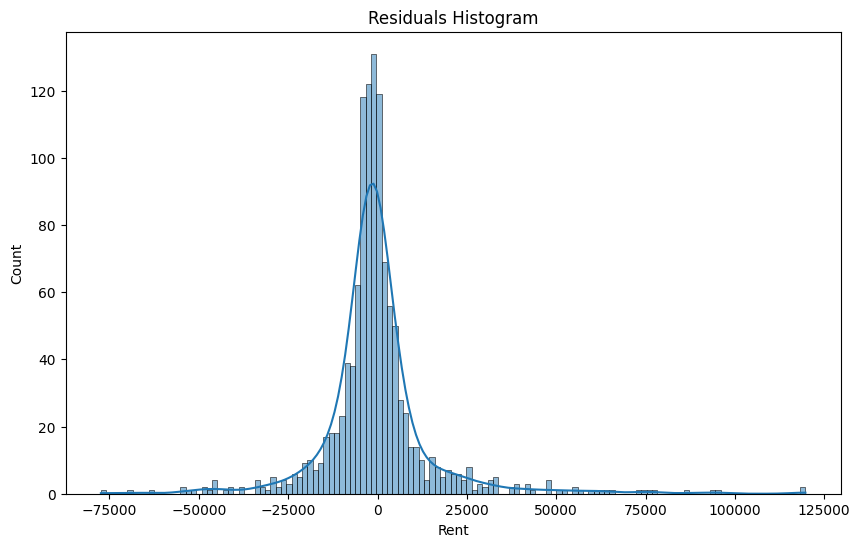

In [49]:
# Check for normality of residuals using a histogram and Q-Q plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Residuals Histogram")
plt.show()

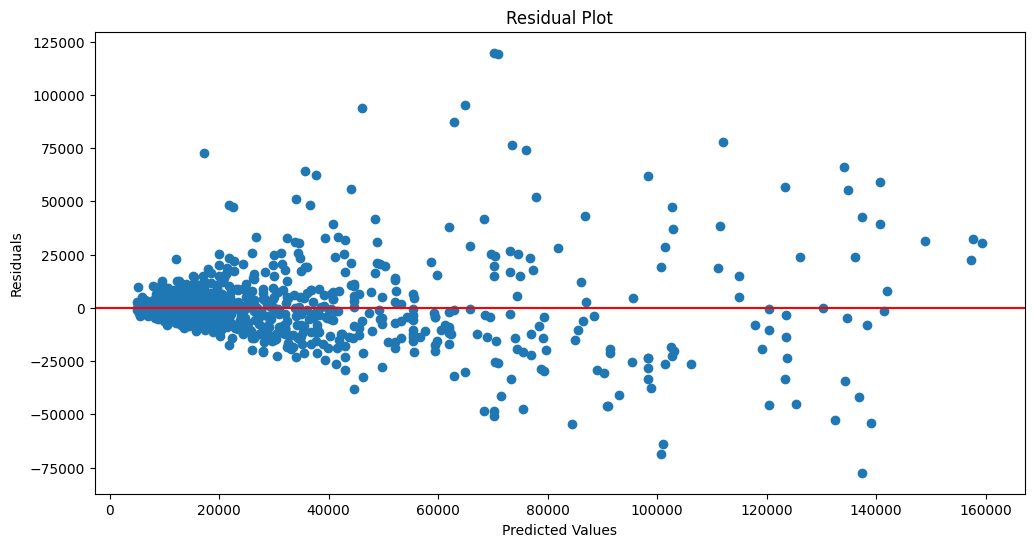

In [50]:
plt.figure(figsize=(12,6))
plt.scatter(y_pred, residuals)
# Setting the red line at y=0
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

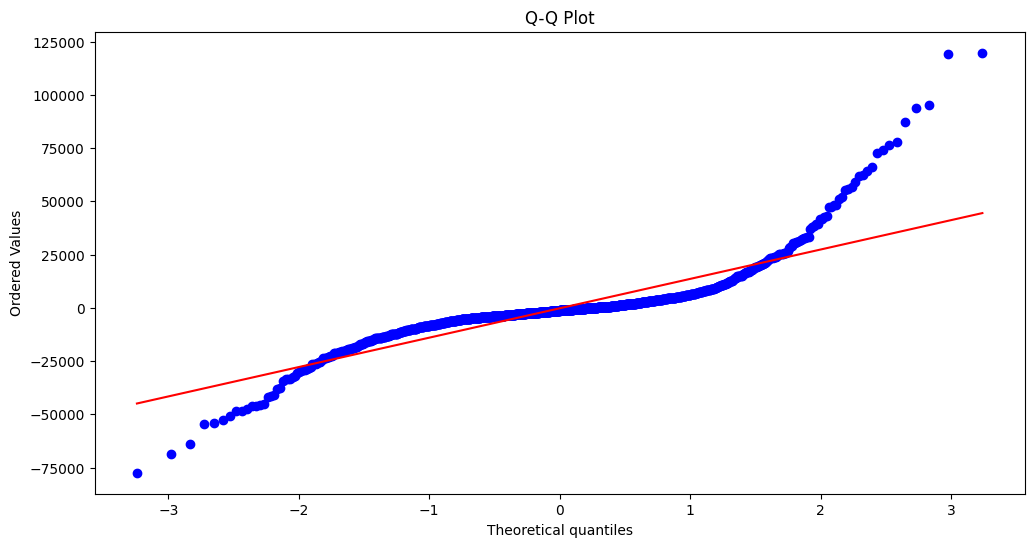

In [51]:
import scipy.stats as stats
import pylab
# Check for normality of residuals using a Q-Q plot
plt.figure(figsize=(12, 6))
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.title("Q-Q Plot")
pylab.show()

### Hyper-Parameter Tuning

In [52]:
parameter_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
}

In [53]:
grid_search = GridSearchCV(estimator=model, param_grid=parameter_grid,
                          scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
# n_jobs speeds up HP tuning process by leveraging multiple CPU cores for parallel processing.

random_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=parameter_grid,scoring='neg_mean_squared_error'
                                   ,cv=5, n_iter=10 ,n_jobs=-1)
# n_iters determines how many random combination of HP will be evaluated during RandomizedSearch

In [57]:
grid_search.fit(X_train, y_train)
best_parameter1 = grid_search.best_params_
print(best_parameter1)

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}


In [58]:
random_search.fit(X_train, y_train)
best_parameter2 = random_search.best_params_
print(best_parameter2)

{'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01}


In [59]:
best_model = GradientBoostingRegressor(n_estimators=200, max_depth=10, learning_rate=0.01)
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=200)

### Feature Importance

In [55]:
# features_imp = model.feature_importances_
# importance = sorted(zip(features_imp, X_train.columns), reverse=True)
# for imp, feat in importance:
#     print(feat, ":", round(imp, 3))